## Manifold Learning And Autoencoders

We try to see if we can get some intuition about the geometry and topology of the MNIST dataset.

### Loading required packages and data:

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
train = pd.read_csv("./data/train.csv")

X_train = train.iloc[:,1:].values
X_train = X_train.reshape(X_train.shape[0], 28, 28) #reshape to rectangular
X_train = X_train/255 #pixel values are 0 - 255 - this makes puts them in the range 0 - 1

y_train = train["label"].values

In [3]:
#define a function that allows us to see the digits:
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

Let's pick one image to be our default image - just so we have a reference point. We'll call this the **"eight" image** - simply because, well it's an eight:

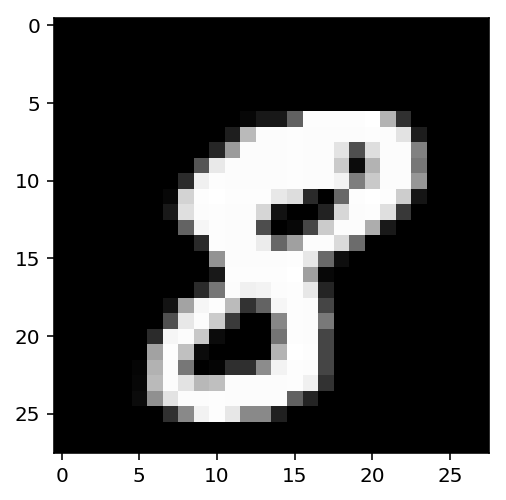

In [4]:
img = X_train[10]
show(img)

Ok so our digits are in a space in which every pixel is a variable or a feature. Since there are 28*28 = 784 pixels per image we can thing of the images as sitting in $\mathbb{R}^{784}$ - a real 784 dimensional vector space.

This space is very high dimensional and most dimensionality reduction techniques try to exploit the assumption that not all of these dimension are needed to distinguish between the digits (or more generally extract features or achieve some learning task).

Where does this intuition come from? To see this let's generate a point uniformly at random in the unit 784 dimensional hypercube and see what it looks like. We pick points in the hypercube simply because we normalized the pixel intensities. 

Maybe a 784-hypercube sounds intimidating but it has a very easy mathematical definition: it's the set composed of all  vectors in $\mathbb{R}^{784}$ that have all coordinates less than or equal to one: $$\{x \in \mathbb{R}^{784} | |x_i| < 1\} = [0,1]^{784}$$

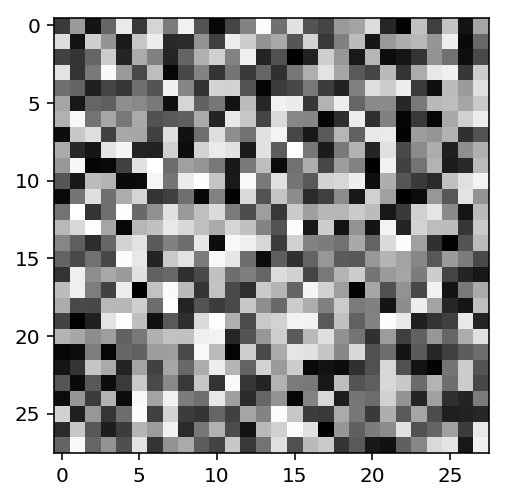

In [5]:
#generating a random 28 by 28 image:
rand_img = np.random.randint(0, 255, (28, 28))
rand_img = rand_img/255.0

show(rand_img)

Doesn't look like anything to me!

We can try to sample at random many times but unless we get extremely lucky all we'll get is static and nothing resembling an actual digit. This is good empirical evidence that the meaningful images - in this case images of digits, are clustered in smaller dimensional subsets in the original 784 dimensional pixel space. This is what is called the **manifold hypothesis**. And the promise is that if we better understand the structure of the manifold we will have an easier time building machine learning systems.

Before we try to see how to figure out the manifold structure let's take a closer look at out space. For example what happens if we start at the point of a digit and start traveling in a random direction? Will we get any meaningful images?

In [6]:
rand_direction = np.random.rand(28, 28) 

### Moving in a random direction away from a digit in the 784 dimensional image space:

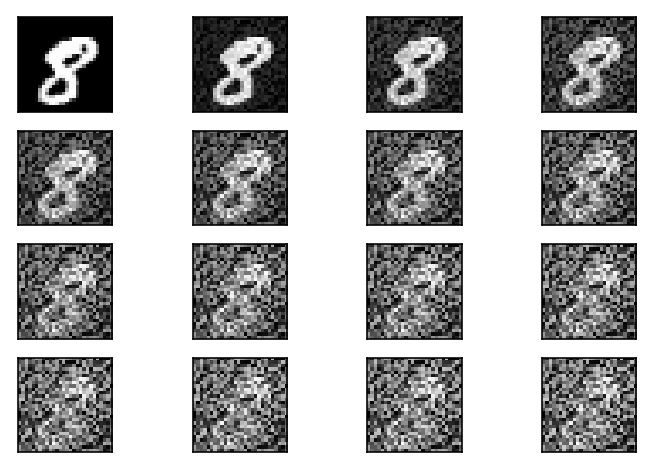

In [7]:
for i in range(16):
    plt.subplot(4,4,i+1)
    show(img + i/4*rand_direction)    
    plt.xticks([])
    plt.yticks([])

We can see that as we move away from the digit, the images we encounter become less and less distinguishable. At first we can still see the eight shape but before we know it we're back in static land.

Perhaps a good analogy here is that of a solar system: the surface of our planets are the manifolds we're interested in, one for each digit. Now say you're on the surface of the earth which is a 2-manifold and you start moving in a random direction (let's assume gravity doesn't exist and you can go through solid objects). If you don't understand the structure of earth you'll quickly find yourself in space or inside the earth. But if you instead move within the local earth (say spherical) coordinates you will stay on the surface and get to see all the cool stuff. 

There are however some differences: first of all we're in a much higher dimensional space and we're not sure how many dimensions we need to capture the structure of the digit subspaces. Secondly these subspaces could be really crazy looking - think for example two donuts entangled in some weird way. You could in fact get from one manifold to another without going into static space as all.

### Our digits' best friends aka Nearest Neighbors:

Another thing to do to understand better the structure of the image space is to look at what images are closest to the "eight" image using some metric. In this case I'll use the sklearn knn wrap with l_2 distance as the metric on the flattened images. 

In [8]:
X_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

knn = NearestNeighbors(5000)

knn.fit(X_flat[:5000])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5000, p=2, radius=1.0)

In [9]:
distances, neighbors = knn.kneighbors(img.flatten().reshape(1, -1))
neighbors = neighbors[0]
distances = distances[0]

### Histogram of L_2 distances from the "eight" digit:

(array([    8.,    28.,   120.,   408.,   852.,  1346.,  1257.,   711.,
          218.,    51.]),
 array([  6.93865358,   7.66124204,   8.38383049,   9.10641895,
          9.8290074 ,  10.55159586,  11.27418432,  11.99677277,
         12.71936123,  13.44194968,  14.16453814]),
 <a list of 10 Patch objects>)

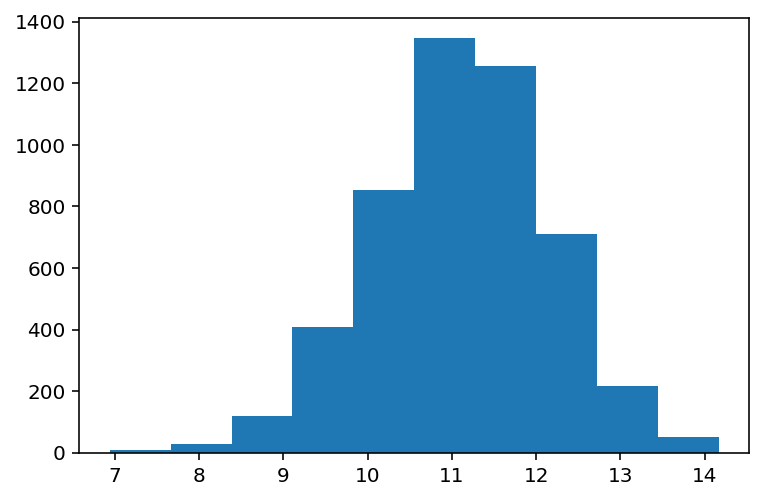

In [10]:
plt.hist(distances[1:])

The distances of the first 5000 images from the "eight" image is roughly normally distributed - in fact it's much more well behaved than I expected. At first I though I'd see multiple modes and a higher variance given that we have different classes. 

### 32 Nearest Neighbors for our "eight" image:

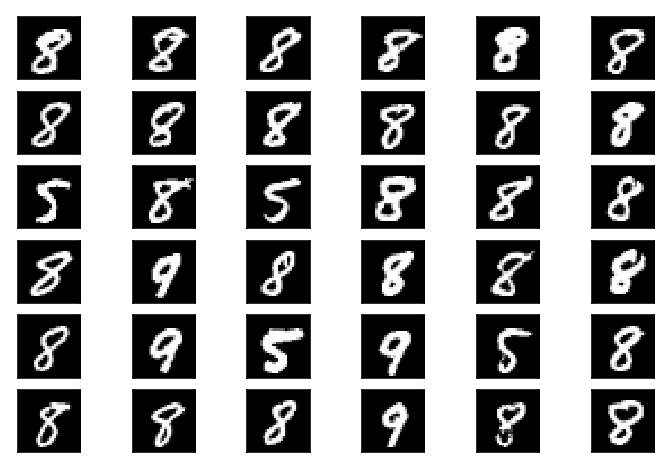

In [11]:
for digit_num, num in enumerate(neighbors[:36]):
    plt.subplot(6,6,digit_num+1)
    grid_data = X_train[num]  # reshape from 1d to 2d pixel array
    show(grid_data)
    plt.xticks([])
    plt.yticks([])

Interesting stuff - most of the neighbors are also eight but not all - we see some five and some nines as well. However all in all it looks like KNN would be a decent way to attack this problem - maybe with 5 or 10 neighbors.

### Learning the manifold with an autoencoder:

Ok so how do we figure out what (combinations of) dimensions in the image space are important? One option would be to hand engineer features - for examples the mean of all pixels is probably a good feature to have. Other worthwhile features would be the slant, and the vertical or horizontal symmetry. 

But we want do to machine learning not hand-craft features because we're lazy and machines tend to better capture important features in messy datasets. There are many ways to try to reduce the dimensionality - hereI am going to use an autoencoder. I like autoencoders because they have a nice intuitive appeal and you can train them relatively fast. 

An **autoencoder ** is a feed- forward neural network who tries to learn a lower dimensional representation of our data. It does that by decreasing the number of layers in the middle of the network and then increasing it back to the dimension of the original image. 

Since the autoencoder is forced to reconstruct the images from a smaller representation it discards any variation that it doesn't find useful. Here is a great description form the [Deep Learning](http://www.deeplearningbook.org/contents/autoencoders.html) book:

"The important principle is that the autoencoder can aﬀord to represent only the variations that are needed to reconstruct training examples. If the data generating distribution concentrates near a low-dimensional manifold, this yields representations that implicitly capture a local coordinate system for this manifold: only the variations tangent to the manifold around x need to correspond to changes in h=f(x)."

Let's build an autoencoder in keras - It will have 3 hidden layers with 64, 2, and 64 units respectively. Our model will compress the image to a 2-dimensional vector and then try to reconstruct it . Note that we don't use the target y at all, instead we use X_flat for both the input and the target i.e. we're doing unsupervised learning.

In [12]:
input_img = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_img)

encoded = Dense(2)(encoded) #keep it linear here.

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input=input_img, output=decoded)

/home/kumar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.fit(X_flat, X_flat, batch_size = 128,
                nb_epoch = 10, verbose = 3)

/home/kumar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [14]:
encoder = Model(input = input_img, output = encoded)

#building the decoder:
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-2]
encoded_layer_2 = autoencoder.layers[-1]


decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = Model(input=encoded_input, output=decoder)

### 2D - representation learned by the autoencoder:

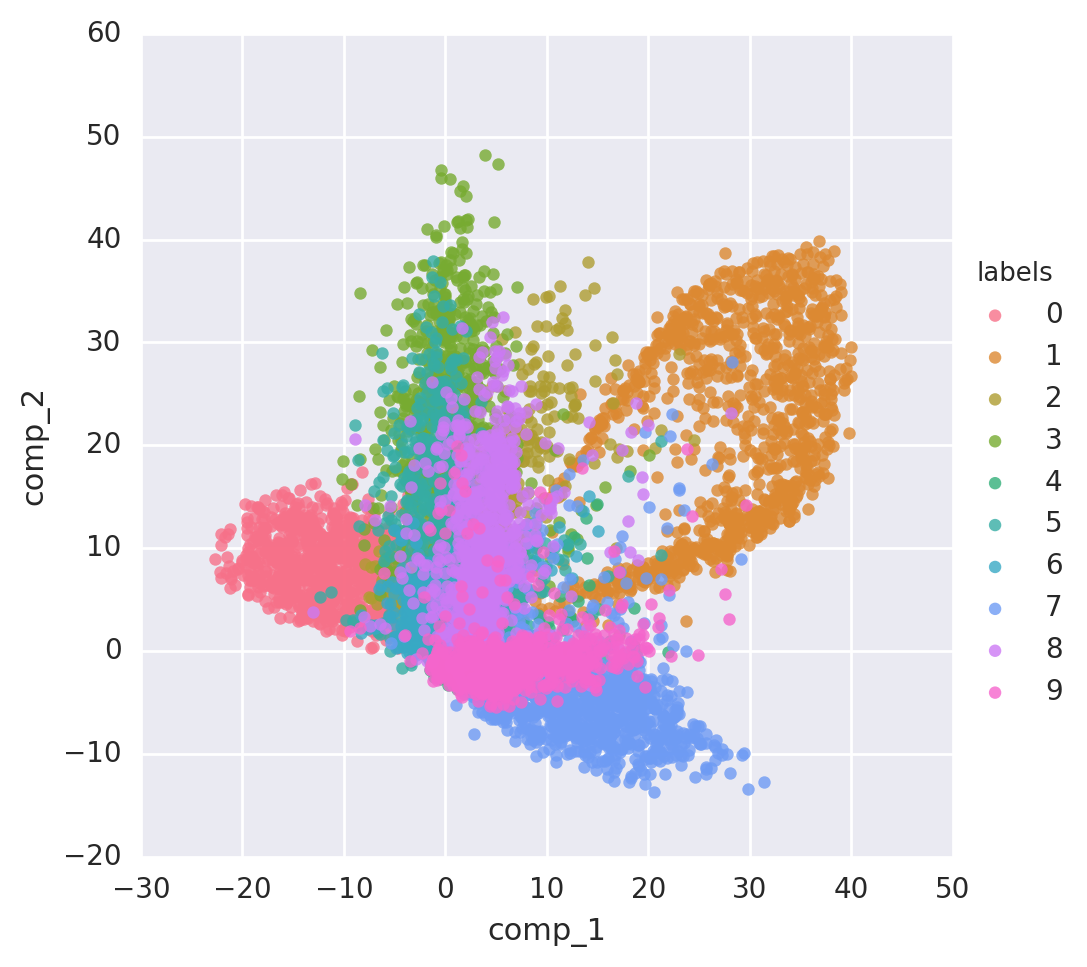

In [15]:
import seaborn as sns

X_proj = encoder.predict(X_flat[:10000])
X_proj.shape

proj = pd.DataFrame(X_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:10000]
sns.lmplot("comp_1", "comp_2",hue = "labels", data = proj, fit_reg=False)

We can see the autoencoder does a decent job of separating certain classes like 1, 0 and 4. It does better than PCA but is not as good as TSNE. The autoencoder learns a better representation that simpler methods like PCA because it can detect nonlinearities in the data due to its relu activations. In fact if we used linear activation functions and only one hidden layer we would have recovered the PCA case.


Can we recover the images from their 2-dimensional represetation?

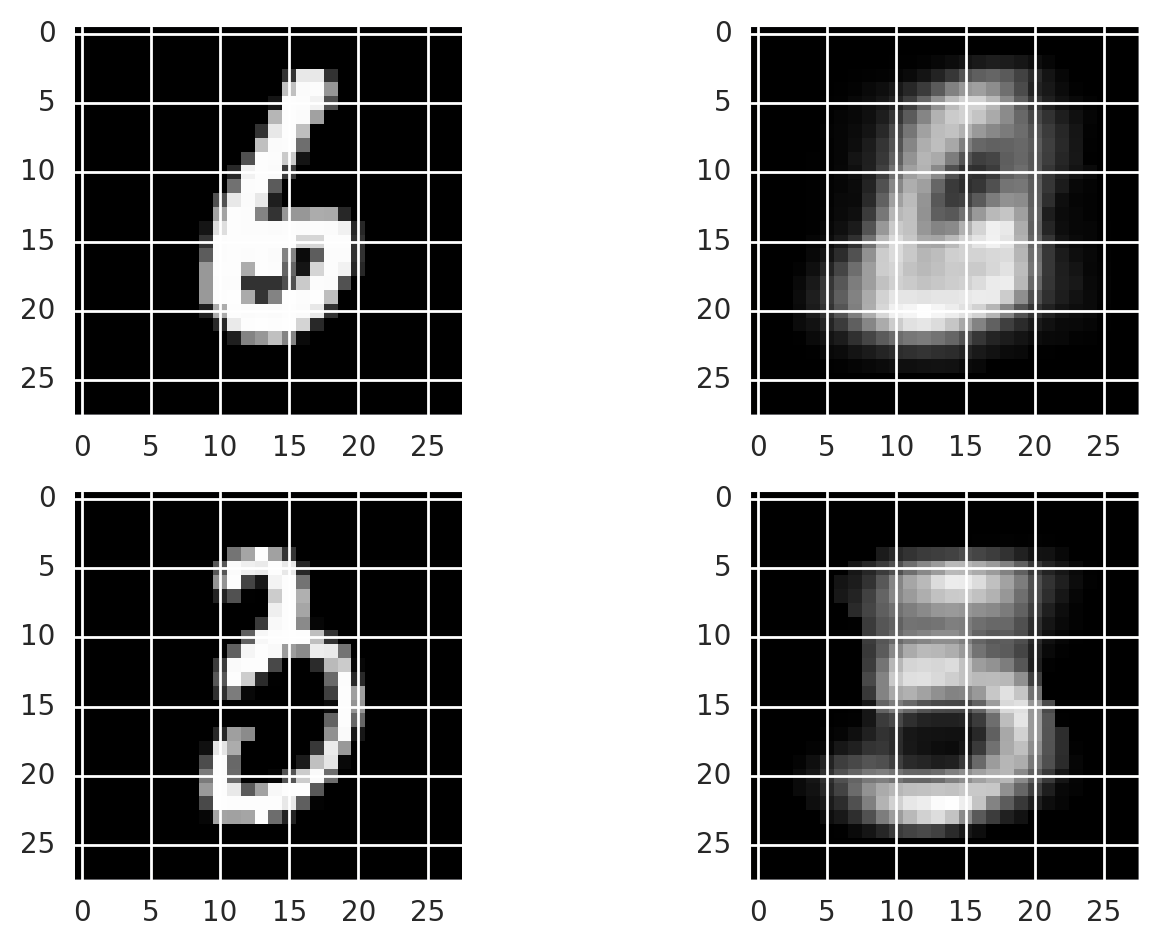

In [16]:

#how well does the autoencoder decode:w1
plt.subplot(2,2,1)
show(X_train[160])
plt.subplot(2,2,2)
show(autoencoder.predict(np.expand_dims(X_train[160].flatten(), 0)).reshape(28, 28))
plt.subplot(2,2,3)
show(X_train[150])
plt.subplot(2,2,4)
show(autoencoder.predict(np.expand_dims(X_train[150].flatten(), 0)).reshape(28, 28))

Not really - the encoding decoding process is quite lossy - but that makes sense since we're converting a 784 dimensional vector into 2 dimensions.

### Generating new digits by moving in the latent 2D - space:

Now the hope is that the new 2-D representation of the data is a good coordinate system for the subspace of the data that is actually meaningful i.e. the digits. One (hand-wavy) way to check this is to see what happens if we sample points in the 2-D representation space and move in various directions - do we get some meaningful change in the decoded image of the path or just noise as we did in the original space?

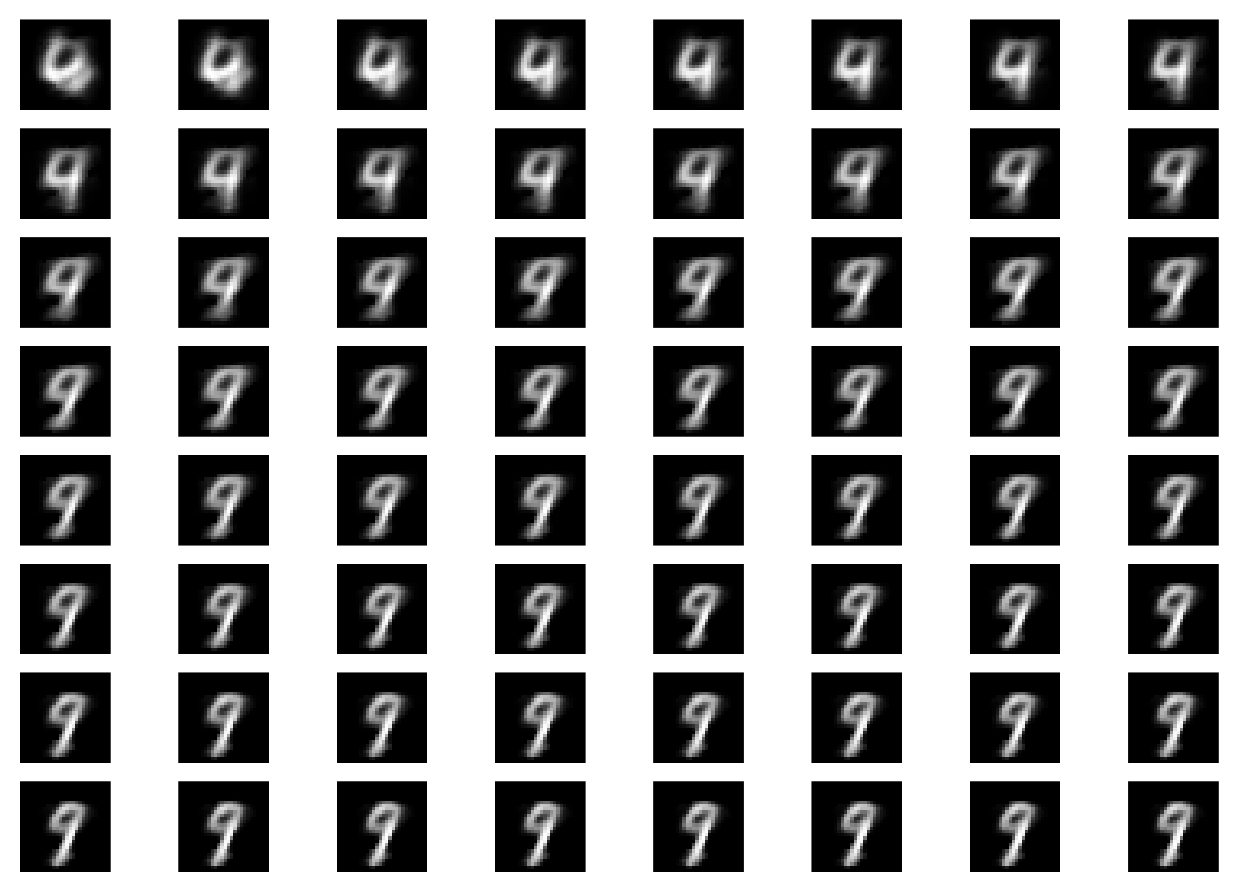

In [17]:
#moving along the x axis:
for i in range(64):
    plt.subplot(8,8,i+1)
    pt = np.array([[i/3,0]])
    show(decoder.predict(pt).reshape((28, 28)))
    plt.xticks([])
    plt.yticks([])

Pretty neat! We see that moving in a given direction in the 2D representation corresponds to staying on the digits manifolds in the original space. We never end up in static space. Sure not all the images are exactly digits but they are all digit-like. You can also clearly see the transition from one class to another.

Note that the way we're generating images here doesn't have very good statistical properties since we have to look at the 2-d plot first. Using a variational autoencoder makes the generative process more rigorous but we'll settle for this.

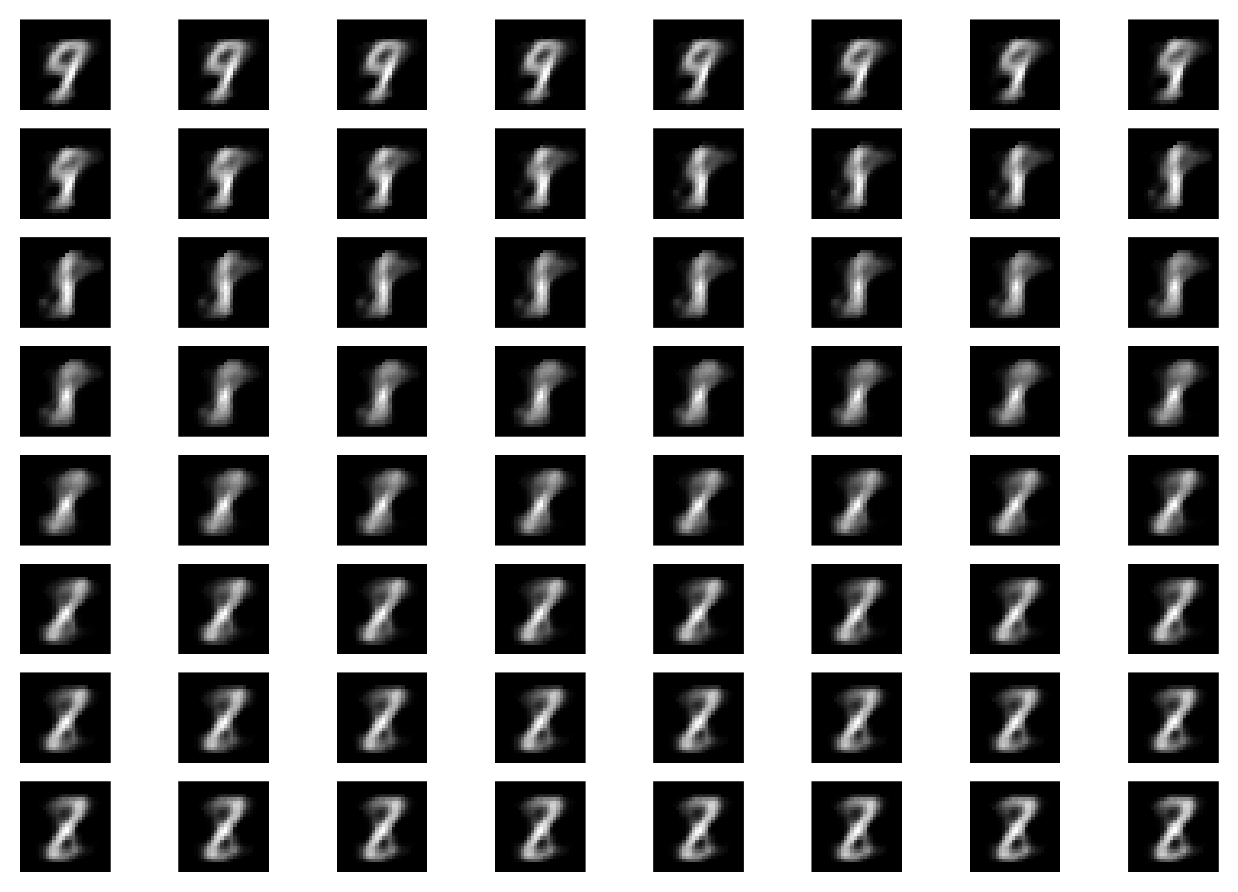

In [18]:
#moving along the y axis:
for i in range(64):
    plt.subplot(8,8,i+1)
    pt = np.array([[10,i/3]])
    show(decoder.predict(pt).reshape((28, 28)))
    plt.xticks([])
    plt.yticks([])

### References:

-  [Autoencoder in Keras](https://blog.keras.io/building-autoencoders-in-keras.html) by Francois Chollet

- [Deep Learning Book Ch 14](http://www.deeplearningbook.org/contents/autoencoders.html) by Ian Goodfellow and Yoshua Bengio and Aaron Courville.